# Nuclear Mass Neural Net

This short tensorflow toy trains a standard neural network to output binding energy based on an input neutron and proton number. The first code block uses a saved model and should stand by itself, but the training stuff is down below.

Also included are a couple of widgets. Be sure to run the first cell first to define some functions, then the widgets should run fine provided you have the environment set up correctly.

In [96]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import h5py
import pandas as pd
from sklearn.externals import joblib
import sklearn.linear_model as skl
from pylab import plt, mpl
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)

# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# input N,Z return model estimated binding energy
def BE(N, Z):
    # Hard code the data averages
    nucleus=xscaler.transform(np.array([[Z,N]]))
    [[BE]] = yscaler.inverse_transform(massmodel.predict(nucleus,verbose=0))
    return BE

def GenerateMasses():
    
    nuclei=[[0,0]]
    for zi in range(1,120):
        for ni in range(0,160):
            nuclei=np.append(nuclei,xscaler.transform([[zi,ni]]),axis=0)
            
    energies=yscaler.inverse_transform(massmodel.predict(nuclei,verbose=0)).squeeze()
    nuclei = xscaler.inverse_transform(nuclei)
    a_sum=nuclei[:,0]+nuclei[:,1]
    return pd.DataFrame({'A':a_sum,'Z':nuclei[:,0],'N':nuclei[:,1],'Energies':a_sum*energies[:],'Energies per A':energies[:]})

def CalcSepEn(Z,A1,A2):
    Nucleus=predicted.loc[lambda predicted: predicted.Z==Z, :]
    Nucleus=Nucleus.loc[(Nucleus['A'] >= A1) & (Nucleus['A'] <= A2)]
    Nucleus['NeutronSeparationEnergies'] = Nucleus['Energies'].diff(+1)
    return Nucleus

# And now to load scaler

xscaler = joblib.load(xscaler_filename)     
yscaler = joblib.load(yscaler_filename)     
 
# load our pretrained model
massmodel = tf.keras.models.load_model('neuralmasses_testing_bepa.h5', custom_objects={'R2': R2})

# Generate a massive mass chart
predicted=GenerateMasses()

/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/kyle/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


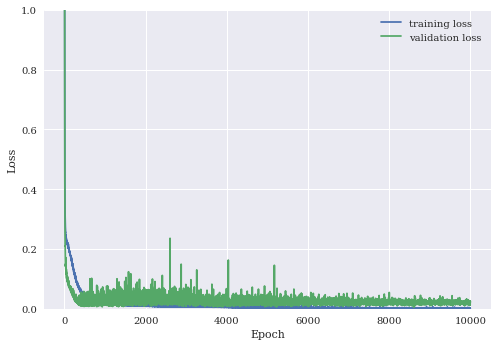

500/500 [==============================] - 1s 2ms/sample - loss: 0.0060 - R2: 0.9896
Test Loss: 0.005974
Test R2: 0.9896


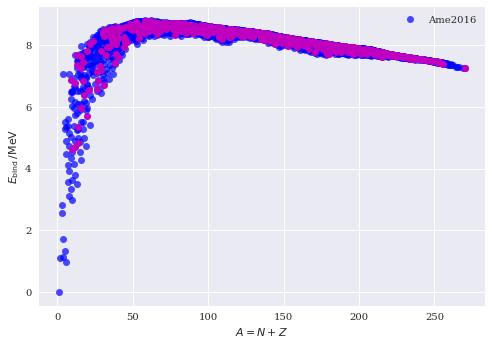

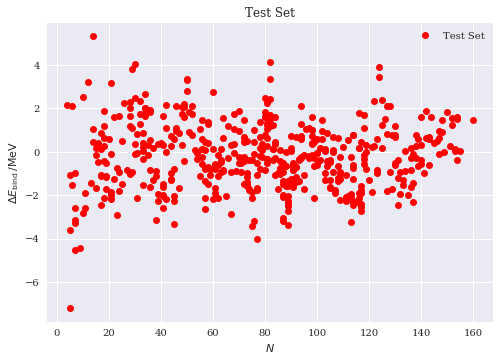

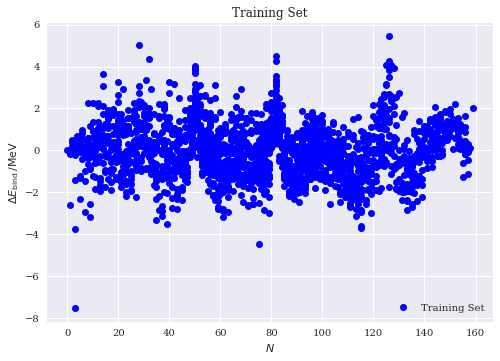

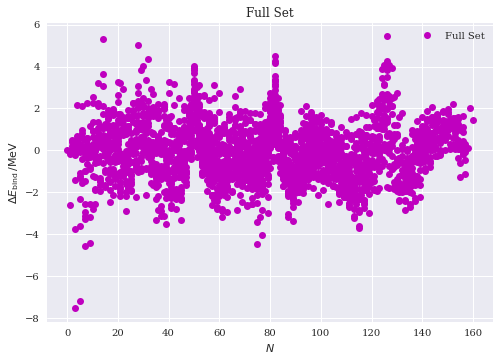

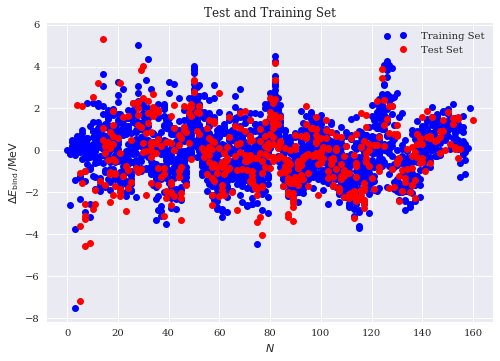

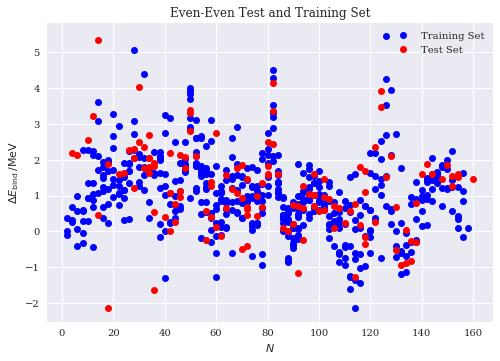

In [97]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import h5py
import pandas as pd
import sklearn.linear_model as skl
from pylab import plt, mpl
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)
    
# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("MassEval2016.dat"),'r')

# Prevent TensorFlow from showing us deprecation warnings
tf.logging.set_verbosity(tf.logging.ERROR)

# Read the experimental data with Pandas
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000

# Group the DataFrame by nucleon number, A.
#Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
#Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])
A = Masses['A']
Z = Masses['Z']
N = Masses['N']
NZdiff = Masses['N']-Masses['Z']
Element = Masses['Element']
Energies = Masses['Ebinding']
## All above comes from another notebook

# Build input array
xx = (Z.as_matrix()[:],N.as_matrix()[:])
xx = np.asarray(xx)
xx = xx.T
aa = np.sum(xx,axis=1)
yy = (Energies.as_matrix()[:])
yy = np.asarray(yy)
yy = yy.T.reshape(-1, 1)

# Get a test set for later
x_train, x_test, y_train, y_test = train_test_split(xx,yy,test_size=0.2,random_state=42)

# Scale input

xscaler_filename = "xscalerbepa.save"

xscaler = MinMaxScaler()
xscaler.fit(x_train)

joblib.dump(xscaler, xscaler_filename) 

xs_train = xscaler.transform(x_train)
xs_test = xscaler.transform(x_test)
xs_full = xscaler.transform(xx)

yscaler_filename = "yscalerbepa.save"

yscaler = RobustScaler()
yscaler.fit(y_train)

joblib.dump(yscaler, yscaler_filename) 

ys_train = yscaler.transform(y_train)
ys_test = yscaler.transform(y_test)
ys_full = yscaler.transform(yy)

history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,1)
plt.show()

# test loss calculation

[test_loss,test_R2]=massmodel.evaluate(xs_test, ys_test, verbose=1)

print('Test Loss: {:.04}'.format(test_loss))
print('Test R2: {:.04}'.format(test_R2))

testen_out=massmodel.predict(xs_test)
trainen_out=massmodel.predict(xs_train)
fullen_out=massmodel.predict(xs_full)

# Shift back for plotting

x_train = xscaler.inverse_transform(xs_train)
x_test = xscaler.inverse_transform(xs_test)
x_full = xscaler.inverse_transform(xs_full)

trainen_out = yscaler.inverse_transform(trainen_out)
testen_out = yscaler.inverse_transform(testen_out)
fullen_out = yscaler.inverse_transform(fullen_out)

a_test=x_test[:,0]+x_test[:,1]
a_train=x_train[:,0]+x_train[:,1]
a_full=x_full[:,0]+x_full[:,1]

en_test=np.asarray(y_test).squeeze()
trainen_test=np.asarray(y_train).squeeze()
fullen_test=np.asarray(yy).squeeze()

diff = (en_test-testen_out.squeeze())*a_test
traindiff = (trainen_test-trainen_out.squeeze())*a_train
fulldiff = (fullen_test-fullen_out.squeeze())*a_full

diff = np.asarray(diff).squeeze()
fulldiff = np.asarray(fulldiff).squeeze()
traindiff = np.asarray(traindiff).squeeze()

x_test_even = x_test[(np.rint(x_test[:,0])%2==0) & (np.rint(x_test[:,1])%2==0)]
diff_even = diff[(np.rint(x_test[:,0])%2==0) & (np.rint(x_test[:,1])%2==0)]
x_train_even = x_train[(np.rint(x_train[:,0])%2==0) & (np.rint(x_train[:,1])%2==0)]
traindiff_even = traindiff[(np.rint(x_train[:,0])%2==0) & (np.rint(x_train[:,1])%2==0)]

# diff = a_test*np.asarray(diff.T).squeeze()
# fulldiff = a_full*np.asarray(fulldiff.T).squeeze()
# traindiff = a_train*np.asarray(traindiff.T).squeeze()

fig, ax = plt.subplots()
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], 'ro',
            label='Ame2016', alpha=0.7,c='b')
ax.plot(a_test, testen_out,'ro',c='m')
ax.legend()
save_fig("Masses2016")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')


plt.title(label="Test Set")
ax.plot(x_test[:,1], diff,'ro',label='Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')

ax.legend()
save_fig("Difference")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_train[:,1], traindiff,'ro',label='Training Set',c='b')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differencetrain")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_full[:,1], fulldiff,'ro',label='Full Set',c='m')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Full Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differencefull")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_train[:,1], traindiff,'ro',label='Training Set',c='b')
ax.plot(x_test[:,1], diff,'ro',label='Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Test and Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differenceboth")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_train_even[:,1], traindiff_even,'ro',label='Training Set',c='b')
ax.plot(x_test_even[:,1], diff_even,'ro',label='Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Even-Even Test and Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("eveneven")
plt.show()

## Separation energy widget

Input a proton number and bounds for total A and watch what the neural net predicts. Note, some experimental data may have been used in the training! 

In [83]:
from ipywidgets import interactive,interact_manual
def f(Z,A1,A2):
    Nucleus=CalcSepEn(int(Z),int(A1),int(A2))
    MakePlot([Nucleus.A], [Nucleus.NeutronSeparationEnergies], ['b'], ['Neutron Separation Energy'], ['$A$','$S_n$'])
    plt.show()

interactive_plot = interact_manual(f, Z="Input Proton Number", A1="Input Minimum A", A2="Input Maximum A")

interactive(children=(Text(value='Input Proton Number', description='Z'), Text(value='Input Minimum A', descri…

## Binding energy widget

Input Z and N to see what the neural net predicts for the binding energy.

In [98]:
from ipywidgets import interactive,interact_manual
def f(Z,N):
    A=int(Z)+int(N)
    pBE=BE(int(N),int(Z))
    print("Binding Energy per Nucleon:",pBE)
    print("Total Binding Energy:",pBE*A)

interactive = interact_manual(f, Z="Input Proton Number", N="Input Neutron Number")


interactive(children=(Text(value='Input Proton Number', description='Z'), Text(value='Input Neutron Number', d…

In [ ]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import h5py
import pandas as pd
import sklearn.linear_model as skl
from pylab import plt, mpl
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)
    
# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("MassEval2016.dat"),'r')

# Prevent TensorFlow from showing us deprecation warnings
tf.logging.set_verbosity(tf.logging.ERROR)

# Read the experimental data with Pandas
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000

# Group the DataFrame by nucleon number, A.
#Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
#Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])
A = Masses['A']
Z = Masses['Z']
N = Masses['N']
NZdiff = Masses['N']-Masses['Z']
Element = Masses['Element']
Energies = Masses['Ebinding']
## All above comes from another notebook

# Build input array
xx = (Z.as_matrix()[:],N.as_matrix()[:])
xx = np.asarray(xx)
xx = xx.T
aa = np.sum(xx,axis=1)
yy = (Energies.as_matrix()[:])
yy = np.asarray(yy)
yy = yy.T.reshape(-1, 1)

# Get a test set for later
x_train, x_test, y_train, y_test = train_test_split(xx,yy,test_size=0.2,random_state=42)

# Scale input

xscaler_filename = "xscalerbepa.save"

xscaler = MinMaxScaler()
xscaler.fit(x_train)

joblib.dump(xscaler, xscaler_filename) 

xs_train = xscaler.transform(x_train)
xs_test = xscaler.transform(x_test)
xs_full = xscaler.transform(xx)

yscaler_filename = "yscalerbepa.save"

yscaler = RobustScaler()
yscaler.fit(y_train)

joblib.dump(yscaler, yscaler_filename) 

ys_train = yscaler.transform(y_train)
ys_test = yscaler.transform(y_test)
ys_full = yscaler.transform(yy)

nodes = 50
activation="relu"
model=tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(nodes,input_shape=(2,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(1)) #Add the output layer
model.compile(tf.keras.optimizers.Adam(lr=0.0001),loss='mean_squared_error',metrics=[R2]) #Adam optimizer and mean squared error loss
#model.compile(tf.keras.optimizers.Adadelta(),loss='mean_squared_error',metrics=[R2]) #Adam optimizer and mean squared error loss
results=model.fit(xs_train,ys_train,epochs=10000, batch_size=8, validation_split=0.2,verbose=1)

history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,1e-3)
plt.show()

# test loss calculation

[test_loss,test_R2]=model.evaluate(xs_test, ys_test, verbose=1)

print('Test Loss: {:.04}'.format(test_loss))
print('Test R2: {:.04}'.format(test_R2))

testen_out=model.predict(xs_test)
trainen_out=model.predict(xs_train)
fullen_out=model.predict(xs_full)

# Shift back for plotting

x_train = xscaler.inverse_transform(xs_train)
x_test = xscaler.inverse_transform(xs_test)
x_full = xscaler.inverse_transform(xs_full)

trainen_out = yscaler.inverse_transform(trainen_out)
testen_out = yscaler.inverse_transform(testen_out)
fullen_out = yscaler.inverse_transform(fullen_out)

a_test=x_test[:,0]+x_test[:,1]
a_train=x_train[:,0]+x_train[:,1]
a_full=x_full[:,0]+x_full[:,1]

en_test=np.asarray(y_test).squeeze()
trainen_test=np.asarray(y_train).squeeze()
fullen_test=np.asarray(yy).squeeze()

diff = en_test-testen_out
traindiff = trainen_test-trainen_out
fulldiff = fullen_test-fullen_out

diff = np.asarray(diff).squeeze()
fulldiff = np.asarray(fulldiff).squeeze()
traindiff = np.asarray(traindiff).squeeze()

x_test_even = x_test[(np.rint(x_test[:,0])%2==0) & (np.rint(x_test[:,1])%2==0)]
diff_even = diff[(np.rint(x_test[:,0])%2==0) & (np.rint(x_test[:,1])%2==0)]
x_train_even = x_train[(np.rint(x_train[:,0])%2==0) & (np.rint(x_train[:,1])%2==0)]
traindiff_even = traindiff[(np.rint(x_train[:,0])%2==0) & (np.rint(x_train[:,1])%2==0)]

# diff = a_test*np.asarray(diff.T).squeeze()
# fulldiff = a_full*np.asarray(fulldiff.T).squeeze()
# traindiff = a_train*np.asarray(traindiff.T).squeeze()

fig, ax = plt.subplots()
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], 'ro',
            label='Ame2016', alpha=0.7,c='b')
ax.plot(a_test, testen_out[:,0],'ro',c='m')
ax.legend()
save_fig("Masses2016")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')


plt.title(label="Test Set")
ax.plot(x_test[:,1], a_test*diff[:,0],'ro',label='Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')

ax.legend()
save_fig("Difference")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_train[:,1], a_train*traindiff[:,0],'ro',label='Training Set',c='b')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differencetrain")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_full[:,1], a_full*fulldiff[:,1],'ro',label='Full Set',c='m')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Full Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differencefull")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_train[:,1], a_train*traindiff[:,1],'ro',label='Training Set',c='b')
ax.plot(x_test[:,1], a_test*diff[:,1],'ro',label='Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Test and Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differenceboth")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_train_even[:,1], traindiff_even[:,0],'ro',label='Training Set',c='b')
ax.plot(x_test_even[:,1], diff_even[:,0],'ro',label='Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Even-Even Test and Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("eveneven")
plt.show()

/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/kyle/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Train on 1597 samples, validate on 400 samples
Epoch 1/10000
1597/1597 [==============================] - 3s 2ms/sample - loss: 1.4156 - R2: -0.2505 - val_loss: 1.3719 - val_R2: -0.0983
Epoch 2/10000
1597/1597 [==============================] - 1s 526us/sample - loss: 1.3791 - R2: -0.1385 - val_loss: 1.3350 - val_R2: -0.0782
Epoch 3/10000
1597/1597 [==============================] - 1s 551us/sample - loss: 1.3231 - R2: -0.0926 - val_loss: 1.2636 - val_R2: 0.0030
Epoch 4/10000
1597/1597 [==============================] - 1s 542us/sample - loss: 1.2173 - R2: 0.0284 - val_loss: 1.1346 - val_R2: 0.0145
Epoch 5/10000
1597/1597 [==============================] - 1s 534us/sample - loss: 1.0467 - R2: 0.2176 - val_loss: 0.9370 - val_R2: 0.3963
Epoch 6/10000
1597/1597 [==============================] - 1s 555us/sample - loss: 0.8449 - R2: 0.4833 - val_loss: 0.7519 - val_R2: 0.4747
Epoch 7/10000
1597/1597 [==============================] - 1s 549us/sample - loss: 0.6733 - R2: 0.5828 - val_loss: 0

1597/1597 [==============================] - 1s 515us/sample - loss: 0.1950 - R2: 0.8170 - val_loss: 0.0728 - val_R2: 0.8836
Epoch 118/10000
1597/1597 [==============================] - 1s 531us/sample - loss: 0.1961 - R2: 0.7923 - val_loss: 0.0705 - val_R2: 0.8975
Epoch 119/10000
1597/1597 [==============================] - 1s 518us/sample - loss: 0.1929 - R2: 0.7847 - val_loss: 0.0791 - val_R2: 0.9328
Epoch 120/10000
1597/1597 [==============================] - 1s 537us/sample - loss: 0.1899 - R2: 0.8152 - val_loss: 0.0711 - val_R2: 0.9066
Epoch 121/10000
1597/1597 [==============================] - 1s 540us/sample - loss: 0.1937 - R2: 0.8314 - val_loss: 0.0776 - val_R2: 0.9251
Epoch 122/10000
1597/1597 [==============================] - 1s 523us/sample - loss: 0.1917 - R2: 0.8460 - val_loss: 0.0746 - val_R2: 0.9363
Epoch 123/10000
1597/1597 [==============================] - 1s 568us/sample - loss: 0.1926 - R2: 0.8125 - val_loss: 0.0702 - val_R2: 0.8880
Epoch 124/10000
1597/1597 [==

1597/1597 [==============================] - 1s 537us/sample - loss: 0.1248 - R2: 0.8926 - val_loss: 0.0363 - val_R2: 0.9602
Epoch 234/10000
1597/1597 [==============================] - 1s 548us/sample - loss: 0.1267 - R2: 0.8693 - val_loss: 0.0396 - val_R2: 0.9749
Epoch 235/10000
1597/1597 [==============================] - 1s 558us/sample - loss: 0.1233 - R2: 0.8722 - val_loss: 0.0361 - val_R2: 0.9658
Epoch 236/10000
1597/1597 [==============================] - 1s 534us/sample - loss: 0.1250 - R2: 0.9228 - val_loss: 0.0327 - val_R2: 0.9754
Epoch 237/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.1243 - R2: 0.8695 - val_loss: 0.0356 - val_R2: 0.9764
Epoch 238/10000
1597/1597 [==============================] - 1s 534us/sample - loss: 0.1225 - R2: 0.8925 - val_loss: 0.0365 - val_R2: 0.9743
Epoch 239/10000
1597/1597 [==============================] - 1s 545us/sample - loss: 0.1227 - R2: 0.8952 - val_loss: 0.0410 - val_R2: 0.9560
Epoch 240/10000
1597/1597 [==

1597/1597 [==============================] - 1s 565us/sample - loss: 0.0688 - R2: 0.9239 - val_loss: 0.0166 - val_R2: 0.9864
Epoch 350/10000
1597/1597 [==============================] - 1s 559us/sample - loss: 0.0750 - R2: 0.9250 - val_loss: 0.0217 - val_R2: 0.9805
Epoch 351/10000
1597/1597 [==============================] - 1s 562us/sample - loss: 0.0727 - R2: 0.9089 - val_loss: 0.0216 - val_R2: 0.9871
Epoch 352/10000
1597/1597 [==============================] - 1s 568us/sample - loss: 0.0717 - R2: 0.9133 - val_loss: 0.0405 - val_R2: 0.9327
Epoch 353/10000
1597/1597 [==============================] - 1s 548us/sample - loss: 0.0701 - R2: 0.9482 - val_loss: 0.0199 - val_R2: 0.9750
Epoch 354/10000
1597/1597 [==============================] - 1s 560us/sample - loss: 0.0725 - R2: 0.8871 - val_loss: 0.0357 - val_R2: 0.9593
Epoch 355/10000
1597/1597 [==============================] - 1s 564us/sample - loss: 0.0720 - R2: 0.9500 - val_loss: 0.0142 - val_R2: 0.9872
Epoch 356/10000
1597/1597 [==

1597/1597 [==============================] - 1s 567us/sample - loss: 0.0431 - R2: 0.9708 - val_loss: 0.0160 - val_R2: 0.9886
Epoch 466/10000
1597/1597 [==============================] - 1s 560us/sample - loss: 0.0393 - R2: 0.9561 - val_loss: 0.0327 - val_R2: 0.9838
Epoch 467/10000
1597/1597 [==============================] - 1s 562us/sample - loss: 0.0510 - R2: 0.9526 - val_loss: 0.0150 - val_R2: 0.9777
Epoch 468/10000
1597/1597 [==============================] - 1s 563us/sample - loss: 0.0411 - R2: 0.9547 - val_loss: 0.0128 - val_R2: 0.9845
Epoch 469/10000
1597/1597 [==============================] - 1s 556us/sample - loss: 0.0381 - R2: 0.9665 - val_loss: 0.0522 - val_R2: 0.9535
Epoch 470/10000
1597/1597 [==============================] - 1s 559us/sample - loss: 0.0423 - R2: 0.9472 - val_loss: 0.0177 - val_R2: 0.9852
Epoch 471/10000
1597/1597 [==============================] - 1s 558us/sample - loss: 0.0392 - R2: 0.9558 - val_loss: 0.0108 - val_R2: 0.9853
Epoch 472/10000
1597/1597 [==

1597/1597 [==============================] - 1s 578us/sample - loss: 0.0305 - R2: 0.9640 - val_loss: 0.0254 - val_R2: 0.9781
Epoch 582/10000
1597/1597 [==============================] - 1s 569us/sample - loss: 0.0308 - R2: 0.9673 - val_loss: 0.0208 - val_R2: 0.9838
Epoch 583/10000
1597/1597 [==============================] - 1s 562us/sample - loss: 0.0309 - R2: 0.9588 - val_loss: 0.0189 - val_R2: 0.9814
Epoch 584/10000
1597/1597 [==============================] - 1s 536us/sample - loss: 0.0302 - R2: 0.9611 - val_loss: 0.0197 - val_R2: 0.9705
Epoch 585/10000
1597/1597 [==============================] - 1s 541us/sample - loss: 0.0299 - R2: 0.9570 - val_loss: 0.0582 - val_R2: 0.9707
Epoch 586/10000
1597/1597 [==============================] - 1s 566us/sample - loss: 0.0369 - R2: 0.9572 - val_loss: 0.0175 - val_R2: 0.9798
Epoch 587/10000
1597/1597 [==============================] - 1s 562us/sample - loss: 0.0268 - R2: 0.9618 - val_loss: 0.0181 - val_R2: 0.9790
Epoch 588/10000
1597/1597 [==

1597/1597 [==============================] - 1s 523us/sample - loss: 0.0279 - R2: 0.9605 - val_loss: 0.0204 - val_R2: 0.9845
Epoch 698/10000
1597/1597 [==============================] - 1s 524us/sample - loss: 0.0226 - R2: 0.9696 - val_loss: 0.0138 - val_R2: 0.9841
Epoch 699/10000
1597/1597 [==============================] - 1s 549us/sample - loss: 0.0263 - R2: 0.9597 - val_loss: 0.0166 - val_R2: 0.9876
Epoch 700/10000
1597/1597 [==============================] - 1s 519us/sample - loss: 0.0246 - R2: 0.9671 - val_loss: 0.0206 - val_R2: 0.9905
Epoch 701/10000
1597/1597 [==============================] - 1s 539us/sample - loss: 0.0312 - R2: 0.9588 - val_loss: 0.0144 - val_R2: 0.9885
Epoch 702/10000
1597/1597 [==============================] - 1s 534us/sample - loss: 0.0292 - R2: 0.9644 - val_loss: 0.0229 - val_R2: 0.9882
Epoch 703/10000
1597/1597 [==============================] - 1s 538us/sample - loss: 0.0246 - R2: 0.9817 - val_loss: 0.0391 - val_R2: 0.9820
Epoch 704/10000
1597/1597 [==

### Run a little more

If you want to run further epochs with the output model as a starting point, this cell should do it for you

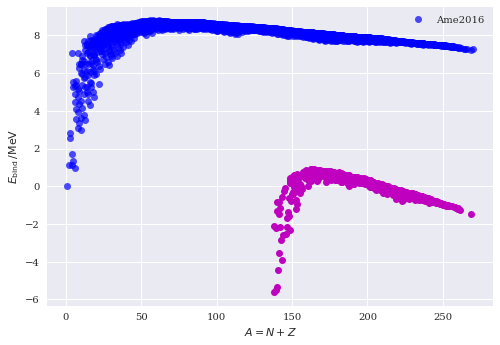

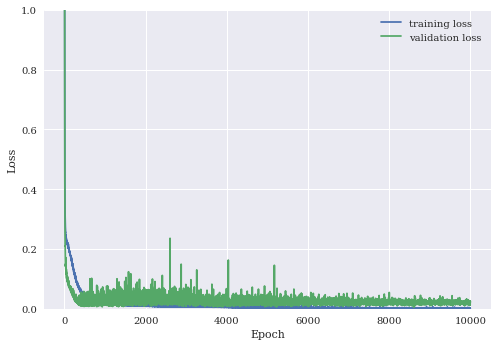

In [71]:
#results=model.fit(xs_train,y_train,epochs=20, batch_size=8, validation_split=0.2,verbose=1)

en_out=model.predict(xs_test)

# Shift back for plotting

x_shift=xs_test
x_shift[:,0]=xs_test[:,0]*np.average(x_test[:,0])+np.average(x_test[:,0])
x_shift[:,1]=xs_test[:,1]*np.average(x_test[:,1])+np.average(x_test[:,1])

a_sum=np.sum(x_shift,axis=1)

fig, ax = plt.subplots()
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], 'ro',
            label='Ame2016', alpha=0.7,c='b')
ax.plot(a_sum, en_out,'ro',c='m')
ax.legend()
save_fig("Masses2016")
plt.show()

history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,1)
plt.show()

### Make some predictions

We can, in principle, hand the neural net a N,Z array, and predict binding energies

In [17]:
N=8
Z=8

Zs=(Z - np.average(xx[:,0])) / np.average(xx[:,0])
Ns=(N - np.average(xx[:,1])) / np.average(xx[:,1])

nucleus=np.array([[Zs,Ns]])

[[BE]] = model.predict(nucleus)

print("Binding Energy Per Nucleon: ",BE)
print("Binding Energy: ",BE*(N+Z))

ValueError: Error when checking input: expected dense_15_input to have shape (3,) but got array with shape (2,)

## Save the model for posterity

Since it takes a long time to train

In [99]:
# This won't overwrite the 'real' trained github file
model.save('neuralmasses_testing_bepa.h5')
